## Configuration

In [24]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import os
import seaborn as sns

#### Receiving inputs

In [25]:
dir_path = 'patients'

input_path = os.path.join(dir_path, 'inputs_to_prediction.json')

inputs_data = pd.read_json(input_path)

inputs_data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,22,0,0,not current,25.19,7.2,150
1,Male,45,1,0,current,25.01,5.6,150
2,Male,75,1,1,former,35.10,9.0,200


#### Loading model

In [26]:
model_name = os.path.join('models', 'hgbm_clf_pipeline.pkl')

loaded_clf = joblib.load(model_name)

loaded_clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease', 'bmi',
                                                   'HbA1c_level',
                                                   'blood_glucose_level']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='No '
                                                                                            'info',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender',
                                                   'smoking_history'])])),
                ('model',
                 HistGradientBoostingClassifier(max_depth=6, random_state=42))])

#### Making prediction

In [27]:
minimize_diabetes_risk_tips = []

# selecting user to make the prediction and generate report
user_index = 2
# Dados do usuário
user_data = inputs_data.copy(deep=True)

user_data = user_data.iloc[[user_index]]

user_data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
2,Male,75,1,1,former,35.1,9.0,200


In [28]:
prediction = loaded_clf.predict_proba(user_data)[:, 1]

prediction = prediction[0]

prediction

0.999575340689966

In [29]:
print(f'{prediction:.2%}')

99.96%


In [30]:
data_path = os.path.join('data', 'diabetes_simple.csv')
df = pd.read_csv(data_path)

df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [31]:
glucoses_levels = df['blood_glucose_level'].unique().tolist()

glucoses_levels.sort()

hbA1c_levels = df['HbA1c_level'].unique().tolist()
hbA1c_levels.sort()

In [32]:
#  variando níveis de glicose no sangue

less_one = None
feature_val = None
for glu in glucoses_levels:
    if user_data.iloc[0, 7] > glu:
        row = user_data.copy(deep=True)
        row.loc[0, 'blood_glucose_level'] = glu

        proba = loaded_clf.predict_proba(row)[:, 1][0]
        
        if less_one is None or proba < less_one:
            less_one = proba
            feature_val = glu

if less_one is not None:
    key = 'glicose no sangue'
    explanation = f'Se você reduzir o seu nível de glicose no sangue para {feature_val}, sua probabilidade de ter diabetes sai de {prediction:2%} para {less_one:2%}'
    tips = [
        'Beba bastante água',
        'Prefira alimentos integrais',
        'Coma mais fibras'
    ]
    
    minimize_diabetes_risk_tips.append({'key': key, 'explanation': explanation, 'tips': tips})
    print(explanation)

Se você reduzir o seu nível de glicose no sangue para 80, sua probabilidade de ter diabetes sai de 99.957534% para 99.957534%


In [33]:
#  variando valores de hbA1c

less_one = None
feature_val = None

for hb in hbA1c_levels:
    
    if user_data.iloc[0, 6] > hb:
        row = user_data.copy(deep=True)
        row.loc[0, 'HbA1c_level'] = hb

        proba = loaded_clf.predict_proba(row)[:, 1][0]
        
        if less_one is None or proba < less_one:
            less_one = proba
            feature_val = hb

if less_one is not None:
    key = 'HbA1c'
    explanation = f'Se você reduzir o seu nível de hemoglobina glicada para {feature_val}, sua probabilidade de ter diabetes sai de {prediction:2%} para {less_one:2%}'
    tips = [
        'Siga um plano alimentar',
        'Realize atividade física regularmente'
    ]
    minimize_diabetes_risk_tips.append({'key': key, 'explanation': explanation, 'tips': tips})
    
    print(explanation)

Se você reduzir o seu nível de hemoglobina glicada para 3.5, sua probabilidade de ter diabetes sai de 99.957534% para 99.957534%


### Comparando com outros pacientes

In [34]:
# importando dataset
data_path = os.path.join('data', 'diabetes_simple.csv')
df = pd.read_csv(data_path)


df.head(5)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [35]:
statics_values = df.describe()
statics_values

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,49510.000000,49510.000000,49510.000000,49510.000000,49510.000000,49510.000000,49510.000000
mean,41.866524,0.075258,0.038921,27.344097,5.527237,137.874692,0.086690
std,22.478834,0.263809,0.193410,6.665177,1.074451,40.996851,0.281382
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.640000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.600000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,88.720000,9.000000,300.000000,1.000000


In [36]:
# plotando localização do paciente no dataset para cada variável indicada

def plot_variable_loc_data(series, value_pacient, att):
    fig, ax = plt.subplots(figsize=(6,4))
    if att == 'hemoglobina glicada':
        hst_color = 'red'
        circle_color = 'green'

    else:
        hst_color = 'blue'
        circle_color = 'black'
    series.plot(ax=ax, kind='hist', bins=20, alpha=0.65, color=hst_color)
    series.plot(ax=ax, kind='kde')

    min_ylim, max_ylim = ax.get_ylim()
    ax.plot(value_pacient*1.005, 800, 'o', color=circle_color)
    ax.annotate('Você se encontra aqui: {:.2f}'.format(value_pacient), xy=(value_pacient*1.005, 1000), 
                xytext=(value_pacient*0.8, max_ylim/2),
                arrowprops=dict(facecolor=circle_color, shrink=0.05), color=circle_color)

    plt.ylabel('Quantidade de pessoas')
    plt.xlabel(f'Níveis de {att}')
    plt.title(f'Níveis de {att} no sangue da população')
    return fig

In [37]:
img_folder = 'images'
img_path = os.path.join(dir_path, img_folder)
if not os.path.exists(img_path):
    os.mkdir(img_path)

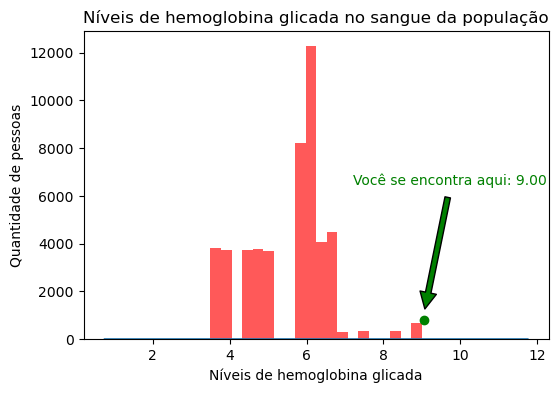

In [38]:
fig = plot_variable_loc_data(df['HbA1c_level'], user_data.iloc[0, 6], 'hemoglobina glicada')


plt.savefig(os.path.join(img_path, f'hba1c_{user_index}.png'), dpi=300)
plt.show()

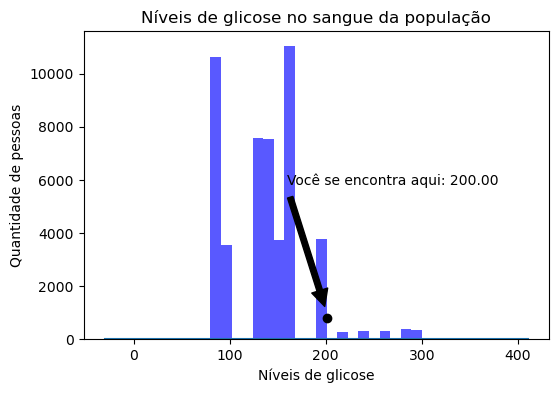

In [39]:
fig = plot_variable_loc_data(df['blood_glucose_level'], user_data.iloc[0, 7], 'glicose')

plt.savefig(os.path.join(img_path,f'glucose_{user_index}.png'), dpi=300)
plt.show()

### Gráfico Termômetro

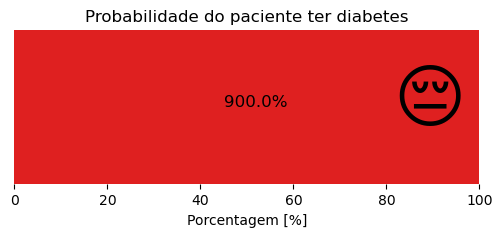

In [46]:
# Define a paleta de cores personalizada
paleta_cores = sns.color_palette("RdYlGn_r", n_colors=101)
cmap = sns.diverging_palette(10, 220, sep=80, n=101, as_cmap=True)


# definindo o paciente i
i = user_index

# Valor de satisfação
valor = float(user_data['HbA1c_level'][2])*100

# Define a cor da barra de acordo com o valor
cor_barra = "red" if valor > 70 else "green"

# Define o tamanho da figura
plt.figure(figsize=(6, 2))

# Cria um gráfico de barra horizontal com um termômetro
ax = sns.barplot(x=[valor], y=[0], color=cor_barra, orient="h", width=0.5)
sns.despine(left=True, bottom=True)

# Adiciona a "cara" correspondente ao valor de satisfação
if valor >= 70:
    ax.text(x=0.97, y=0.32, s="😔", fontsize=50, transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='bottom')
else:
    ax.text(x=0.97, y=0.32, s="😃", fontsize=50, transform=ax.transAxes,
            horizontalalignment='right', verticalalignment='bottom')

# Remove o eixo y e o nome do eixo x
ax.set(yticks=[], xlim=(0, 100), ylim=(-0.2, 0.2), xlabel="")

# Adiciona o título do gráfico
ax.set_title("Probabilidade do paciente ter diabetes")

# Adiciona uma legenda ao eixo x
ax.set_xlabel("Porcentagem [%]")

# Plota o valor acima da barra
ax.text(x=45, y=0, s=str(round(valor,4))+'%', fontsize=12)

# Exibe o gráfico
plt.savefig(os.path.join(img_path, f'prediction_{str(i)}.png'), dpi=300)
plt.show()



### FPDF Report

#### Montar Relatório

In [41]:
#Carregando Imagens para o pdf

images_path = os.path.join(dir_path, 'images')
hbA1c_hist_img = os.path.join(images_path, f'hba1c_{str(user_index)}.png')
blood_glucose_hist_img = os.path.join(images_path, f'glucose_{str(user_index)}.png')
diabetes_risk_thermometer_img = os.path.join(images_path, f'prediction_{str(user_index)}.png')

In [42]:
#Formatando dados do paciente


smoking_history_dict = {
    "never": "Nunca fumou", 
    'No Info': "Sem informação",
    "ever": "Já fumou",
    "not current": "Não fuma atualmente",
    "current": "Fumante",
    "former":"Já foi fumante"
  }

gender = 'Feminino' if user_data.loc[user_index, 'gender'] == 'Female' else 'Masculino'
age = str(user_data.loc[user_index, 'age'])
hypertension = 'Sim' if user_data.loc[user_index, 'hypertension'] == 1 else 'Não'
heart_disease = 'Sim' if user_data.loc[user_index, 'heart_disease'] == 1 else 'Não'
blood_glucose_level = str(user_data.loc[user_index, 'blood_glucose_level'])
smoking_history = smoking_history_dict[user_data.loc[user_index, 'smoking_history']]
HbA1c_level = str(user_data.loc[user_index, 'HbA1c_level'])
bmi = str(user_data.loc[user_index, 'bmi'])

In [43]:
reports_path = os.path.join(dir_path, 'reports')

if not os.path.exists(reports_path):
    os.mkdir(reports_path)


In [47]:
from fpdf import FPDF

#Criando PDF
pdf = FPDF()
pdf.add_page()

#Adicionando Título
pdf.set_font('Arial', 'B', 16)
pdf.cell(40, 10, 'Avaliação do Risco de Diabetes', align = 'L')
pdf.ln(10)

#Adicionando Subtítulo
pdf.set_font('Arial', '', 12)
pdf.set_text_color(200, 0, 0)
pdf.cell(50, 10, 'Resultados apenas para fins acadêmicos ', align = 'L')
pdf.ln(20)

pdf.set_text_color(0, 0, 0)
y_pos = pdf.get_y()
x_pos = pdf.get_x()

#Primeira coluna
pdf.set_font('Arial', '', 12)
pdf.cell(0, 0, 'Dados do paciente:')
pdf.ln(7)

font_size = 10
cell_width = 20
cell_heigth = 0

pdf.set_font('Arial', 'B', font_size)
pdf.cell(15, cell_heigth,  'Genero: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth,  gender)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(12, cell_heigth,  'Idade: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth,  age, align = 'L')
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(24, cell_heigth,  'É Hipertenso: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth,  hypertension)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(47, cell_heigth,  'Possui doença do coração: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth, heart_disease)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(48, cell_heigth,  'Nível de glicose no sangue: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth, blood_glucose_level)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(28, cell_heigth,  'Nível de HbA1c: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth, HbA1c_level)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(10, cell_heigth,  'IMC: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth, bmi)
pdf.ln(5)

pdf.set_font('Arial', 'B', font_size)
pdf.cell(38, cell_heigth,  'Histórico de fumante: ')
pdf.set_font('Arial', '', font_size)
pdf.cell(cell_width, cell_heigth, smoking_history)
pdf.ln(20)

#Segunda coluna
pdf.image(diabetes_risk_thermometer_img, y = y_pos, x = x_pos+85, w = 100, h = 40, type = 'PNG')

#Adicionando visualização do índice de diabetes do usuário
pdf.set_font('Arial', 'B', 12)
pdf.cell(0, 0, 'Onde você se encontra em relação à população', align = 'C')
# pdf.cell(0, cell_heigth, 'Seu risco de diabetes em relação a população', align = 'C')
pdf.ln(5)
y_pos = pdf.get_y()
x_pos = pdf.get_x()
pdf.image(hbA1c_hist_img, y= y_pos, x = x_pos, w = 100, h = 60, type = 'PNG')
pdf.image(blood_glucose_hist_img, y= y_pos, x = x_pos+100, w = 90, h = 60, type = 'PNG')
pdf.ln(75)

#Instrução para diminuição do risco
pdf.cell(50, cell_heigth, 'Como minimizar seu risco de diabetes', align = 'L')
pdf.ln(10)
pdf.set_font('Arial', '', font_size)
for obj in minimize_diabetes_risk_tips:
  pdf.write(5, obj['explanation'])
  pdf.ln(12)
  pdf.set_font('Arial', 'B', font_size)
  pdf.set_text_color(44, 44, 44)
  pdf.text(pdf.get_x()+5, pdf.get_y(),'Dicas para redução do nível de ' + obj['key'])
  pdf.set_text_color(0, 0, 0)
  pdf.set_font('Arial', '', font_size)
  pdf.ln(5)
  for tip in obj['tips']:
    pdf.text(pdf.get_x()+5, pdf.get_y(), '- ' + tip)
    pdf.ln(5)

#Adicionando Referências
pdf.add_page()
pdf.set_font('Arial', 'B', font_size)
pdf.cell(0, cell_heigth, 'Referências', align = 'L')
pdf.set_font('Arial', '', font_size)
pdf.write(5, 'CAMPINAS, U. Hemoglobina Glicada: metas de controle e dicas para manter o equilíbrio. Disponível em: <https://www.unimedcampinas.com.br/blog/cuidado-continuo/hemoglobina-glicada-metas-de-controle-e-dicas-para-manter-o-equilibrio>.')
pdf.ln(10)
pdf.write(5, 'Como equilibrar o nível de glicose no sangue. Disponível em: <https://www.bradescoseguros.com.br/clientes/noticias/noticia/equilibrar-nivel-de-glicose-no-sanque>. Acesso em: 7 maio. 2023.')

#Exportando relatório para o drive
output_path = os.path.join(reports_path, f'diabetes_report_{str(user_index)}.pdf')
pdf.output(output_path, 'F')

''

#### Visualizar PDF

In [50]:
from pdf2image import convert_from_path

images = convert_from_path(output_path)
images[0]  # first page

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: truncated \uXXXX escape (2732182437.py, line 3)